
# E-COMMERCE DATA ANALYSIS USING SQL AND PYTHON
---

**Date**: 2024/12/10  
**Author**: Kade Medley





## **Table of Contents**
---

1. [Executive Summary](#1.-Executive-Summary)
2. [Introduction](#2.-Introduction)
3. [Data Collection](#3.-Data-Collection)
4. [Exploratory Data Analysis (EDA)](#4.-Exploratory-Data-Analysis-EDA)
    - [4a. Daily Orders Trend](#4a.-Daily-Orders-Trend)
    - [4b. Top Cities by Orders](#4b.-Top-Cities-by-Orders)
    - [4c. Average Order Value (AOV)](#4c.-Average-Order-Value-AOV)
    - [4d. Customer Repeat Rate](#4d.-Customer-Repeat-Rate)
    - [4e. Distribution of Order Values](#4e.-Distribution-of-Order-Values)
    - [4f. Hourly Order Counts](#4f.-Hourly-Order-Counts)
5. [Statistical Analysis](#5.-Statistical-Analysis)
    - [5a. Linear Regression on Daily Orders](#5a.-Linear-Regression-on-Daily-Orders)
6. [Key Insights and Recommendations](#6.-Key-Insights-and-Recommendations)


# 1. Executive Summary
---
This analysis explores e-commerce data from the Olist platform, aiming to uncover insights into sales trends, customer behavior, and operational efficiency. Utilizing SQL for data extraction and Python for visualization, the study provides actionable recommendations to enhance business strategies in marketing, inventory management, and customer retention.

# 2. Introduction
---
Understanding the dynamics of e-commerce operations is crucial for strategic decision-making. This project leverages data from Olist, a Brazilian e-commerce platform, to analyze order patterns, customer retention, and sales performance. By integrating SQL for data manipulation and Python for visualization, the analysis offers a comprehensive view of the business's strengths and areas for improvement.


The dataset is sourced from [Kaggle's Olist Brazilian E-commerce Dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce), encompassing transactions from March 2016 to August 2018. The data is loaded into an SQLite database with the following key tables:

- **Orders**: Details of each order, including timestamps for various stages.
- **Customers**: Anonymized customer information and locations.
- **Products**: Product specifications and categories.
- **Sellers**: Information on sellers, their locations, and performance metrics.
- **Order Items**: Breakdown of items within each order, including pricing and shipping costs.
- **Order Reviews**: Customer feedback and satisfaction scores.
- **Payments**: Payment methods and transaction details.

![SQLite database schema](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2473556%2F23a7d4d8cd99e36e32e57303eb804fff%2Fdb-schema.png?generation=1714391550829633&alt=media)



# 3. Data Collection
---

In [1]:
# Import necessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Connect to the SQLite database
db_path = '/kaggle/input/e-commerce-dataset-by-olist-as-an-sqlite-database/olist.sqlite'
db_connection = sqlite3.connect(db_path)

# Function to quickly preview any table
def view_table(table, limit=5):
    query = f"SELECT * FROM {table} LIMIT {limit}"
    return pd.read_sql_query(query, db_connection)

# Preview the 'orders' and 'customers' tables
display(view_table('orders'))
display(view_table('customers'))

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


# 4. Exploratory Data Analysis EDA
---

## 4a. Daily Orders Trend
---
Understanding the daily order volume helps identify growth trends and seasonal patterns.

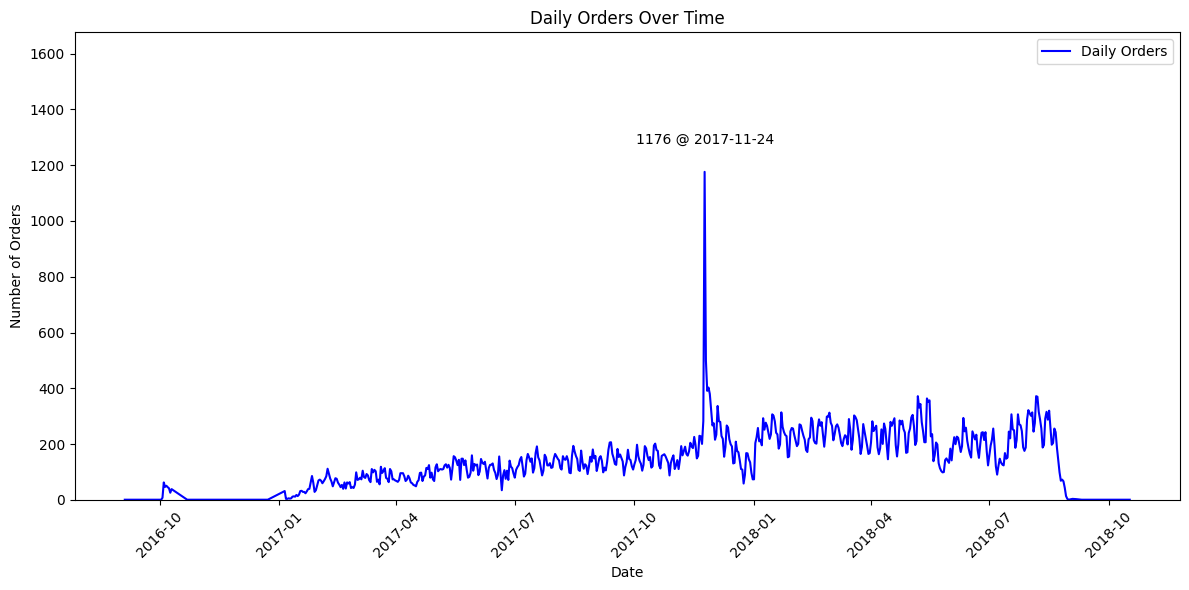

In [2]:
# Daily Orders Trend with Max Count Annotation
daily_orders_query = """
SELECT DATE(order_purchase_timestamp) AS day, COUNT(*) AS order_count
FROM orders
GROUP BY day
ORDER BY day
"""
daily_orders = pd.read_sql_query(daily_orders_query, db_connection)

# Find max order_count and corresponding day
max_count = daily_orders['order_count'].max()
max_day = daily_orders.loc[daily_orders['order_count'].idxmax(), 'day']

plt.figure(figsize=(12, 6))  # Increase figure size for better visibility
plt.plot(pd.to_datetime(daily_orders['day']), daily_orders['order_count'], color='blue', label='Daily Orders')
plt.title('Daily Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)

# Extend y-axis and add annotation
plt.ylim(0, max_count + 500)  # Extend y-axis to leave space for annotation
plt.annotate(f"{max_count} @ {max_day}",
             xy=(pd.to_datetime(max_day), max_count),
             xytext=(pd.to_datetime(max_day), max_count + 100),  # Move annotation upwards
             ha='center')

plt.legend()
plt.tight_layout()
plt.show()


### **Key Insights**

- **Growth Trend**: There is a steady increase in daily orders over time, indicating business growth.
- **Peak Day**: A significant spike on a particular day suggests a seasonal event or promotional campaign.

## 4b. Top Cities by Orders
---
Analyzing the geographic distribution of orders helps in targeting marketing efforts and optimizing logistics.

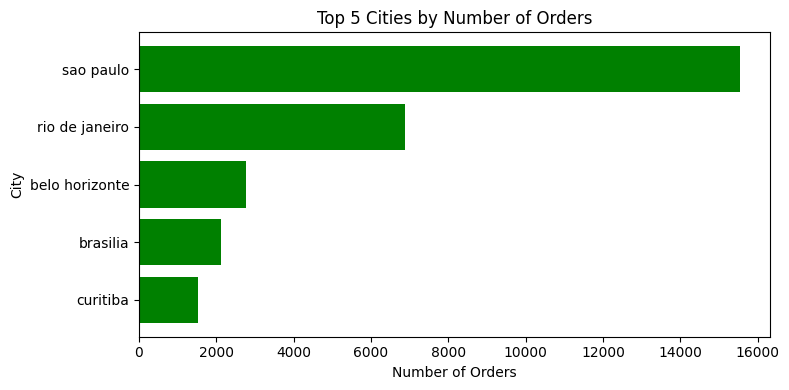

In [3]:
# Top Cities by Orders
top_cities_query = """
SELECT customer_city, COUNT(*) AS city_order_count
FROM orders
JOIN customers USING (customer_id)
GROUP BY customer_city
ORDER BY city_order_count DESC
LIMIT 5
"""
top_cities = pd.read_sql_query(top_cities_query, db_connection)

# Plot the top 5 cities
plt.figure(figsize=(8,4))
plt.barh(top_cities['customer_city'][::-1], top_cities['city_order_count'][::-1], color='green')
plt.title('Top 5 Cities by Number of Orders')
plt.xlabel('Number of Orders')
plt.ylabel('City')
plt.tight_layout()
plt.show()

### **Key Insights**
* **Market Concentration:** A large portion of orders originates from Sao Paulo and Rio de Janeiro, indicating these cities as key markets.
* **Strategic Focus:** Enhancing services and marketing in these top cities can further drive growth.


## 4c. Average Order Value AOV
---
Calculating AOV provides insights into revenue per transaction, guiding pricing and promotional strategies.

In [4]:
# Average Order Value (AOV)
order_items_query = "SELECT order_id, price, freight_value FROM order_items"
order_items = pd.read_sql_query(order_items_query, db_connection)

orders_query = "SELECT order_id FROM orders"
orders_df = pd.read_sql_query(orders_query, db_connection)

# Merge orders with order_items to get total price per order
merged_data = pd.merge(orders_df, order_items, on='order_id', how='inner')
merged_data['total_price'] = merged_data['price'] + merged_data['freight_value']

# Compute average order value
aov = merged_data.groupby('order_id')['total_price'].sum().mean()
print(f"Average Order Value (AOV): {aov:.2f} BRL")
# Business relevance: AOV helps assess profitability, pricing strategy, and upselling opportunities.


Average Order Value (AOV): 160.58 BRL


### **Key Insights**

- **AOV Calculation**: The average order value stands at approximately 160.58 BRL.
- **Strategic Implications**: Understanding AOV assists in setting pricing strategies and identifying opportunities for upselling.

## 4d. Customer Repeat Rate
---
Assessing the proportion of repeat customers informs retention strategies and customer loyalty programs.

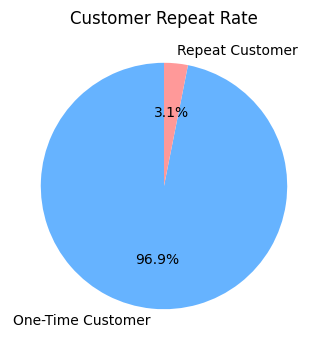

In [5]:
# Customer Repeat Rate
# 'customer_unique_id' is obtained by joining 'customers' and 'orders' tables.
repeat_query = """
WITH customer_order_counts AS (
    SELECT c.customer_unique_id, COUNT(*) AS order_count
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
    GROUP BY c.customer_unique_id
)
SELECT CASE WHEN order_count > 1 THEN 'Repeat Customer' ELSE 'One-Time Customer' END AS customer_type,
       COUNT(*) AS num_customers
FROM customer_order_counts
GROUP BY customer_type
"""
repeat_df = pd.read_sql_query(repeat_query, db_connection)

# Plot the repeat vs one-time customers
plt.figure(figsize=(4,4))
plt.pie(repeat_df['num_customers'], labels=repeat_df['customer_type'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Customer Repeat Rate')
plt.show()

### **Key Insights**

- **Low Retention**: Only 3.1% of customers are repeat buyers.
- **Strategic Focus**: Implementing loyalty programs or targeted marketing can improve retention rates.


## 4e. Distribution of Order Values
---
Understanding the distribution of order values helps identify spending patterns and potential areas for revenue optimization.

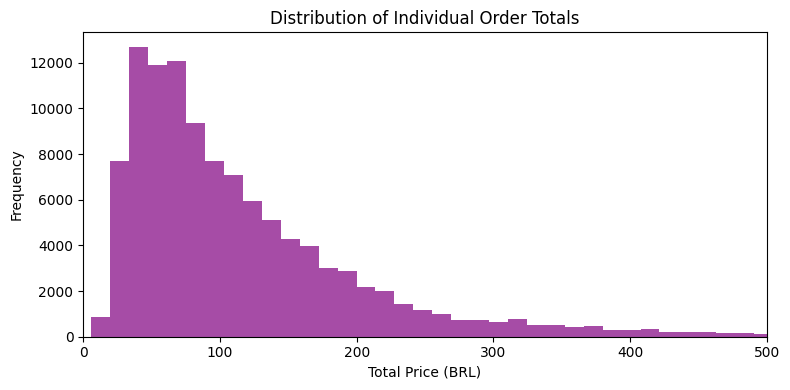

In [6]:
# 5e. Distribution of Order Values
plt.figure(figsize=(8,4))
plt.hist(merged_data['total_price'], bins=500, color='purple', alpha=0.7)
plt.title('Distribution of Individual Order Totals')
plt.xlabel('Total Price (BRL)')
plt.ylabel('Frequency')
plt.xlim(0, 500)  # Focus on lower end, assuming most orders < 500 BRL
plt.tight_layout()
plt.show()

# Insight: Most orders are clustered at lower values; strategies to increase order value could boost revenue.


### **Key Insights**

- **Spending Patterns**: A majority of orders are below 500 BRL, indicating potential for upselling higher-value products.
- **Revenue Optimization**: Implementing bundled offers or premium product placements can enhance average spending.


## 4f. Hourly Order Counts
---
Analyzing orders by the hour of the day can optimize staffing and marketing efforts.

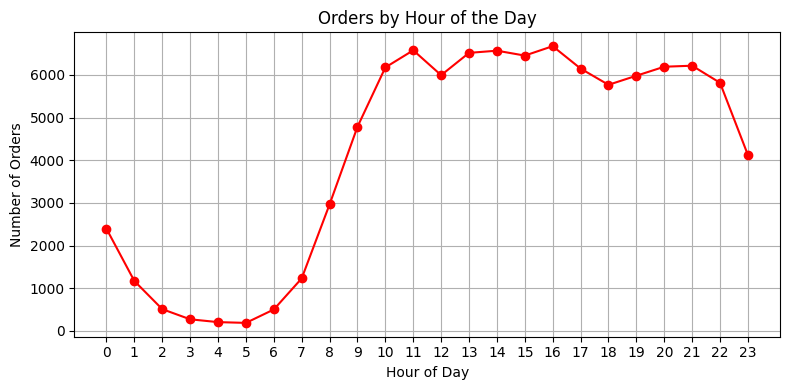

In [7]:
# Hourly Order Counts
hourly_query = """
SELECT CAST(STRFTIME('%H', order_purchase_timestamp) AS INTEGER) AS order_hour,
       COUNT(*) AS order_count
FROM orders
GROUP BY order_hour
ORDER BY order_hour
"""
hourly_orders = pd.read_sql_query(hourly_query, db_connection)

# Plot hourly order counts
plt.figure(figsize=(8,4))
plt.plot(hourly_orders['order_hour'], hourly_orders['order_count'], marker='o', color='red')
plt.title('Orders by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.xticks(range(0,24))
plt.grid(True)
plt.tight_layout()
plt.show()

# Insight: Peak hours between 10 AM to 9 PM suggest optimal times for promotions and customer support.

### **Key Insights**

- **Peak Hours**: Orders peak between 10 AM and 9 PM, aligning with typical shopping hours.
- **Operational Efficiency**: Aligning staffing and support services during these peak times can enhance customer experience.


# 5. Statistical Analysis
---

## 5a. Linear Regression on Daily Orders

Applying linear regression helps quantify the growth trend in daily orders and assess its significance.

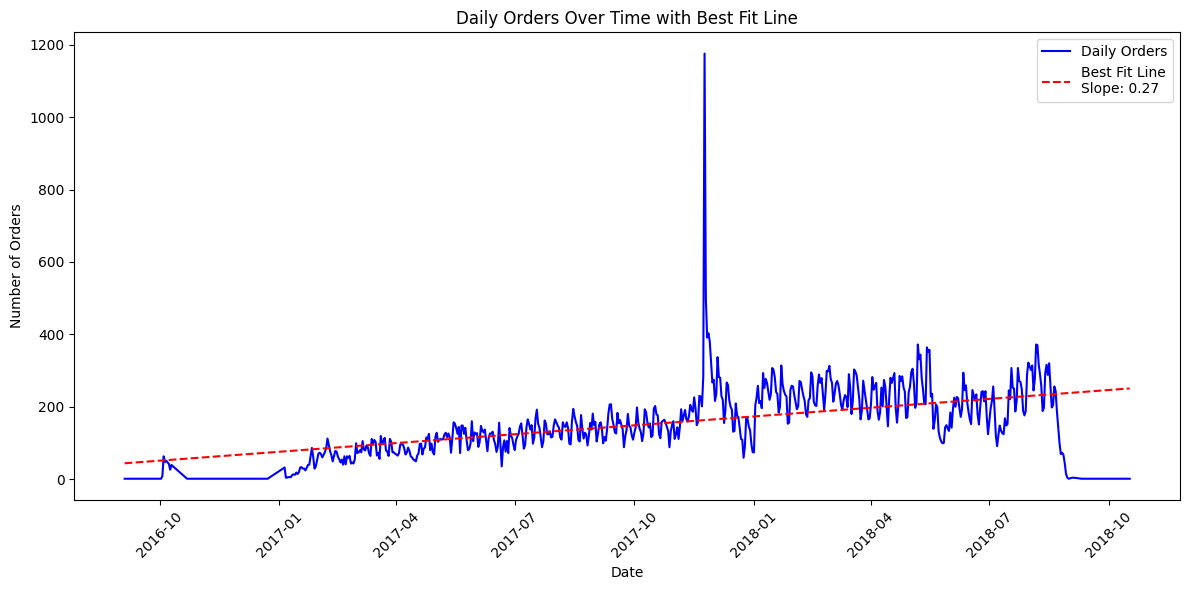

Slope (Growth Rate): 0.27
P-Value: 1.10e-47
R-squared Value: 0.28


In [8]:
# Linear Regression on Daily Orders

from scipy.stats import linregress

# Step 1: Prepare data for linear regression
# Convert the 'day' column to a numeric format (days since the start date) for regression calculations.
daily_orders['day_numeric'] = (pd.to_datetime(daily_orders['day']) - pd.to_datetime(daily_orders['day']).min()).dt.days

# Assign the numeric days to x (independent variable) and order counts to y (dependent variable)
x = daily_orders['day_numeric']
y = daily_orders['order_count']

# Step 2: Perform linear regression
# Calculate the slope (growth rate), intercept (starting point), and additional statistics for the regression line.
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Step 3: Plot the data with the line of best fit
plt.figure(figsize=(12, 6))  # Create a larger figure for better visualization
plt.plot(
    pd.to_datetime(daily_orders['day']),  # Plot the original dates on the x-axis
    daily_orders['order_count'],          # Plot the order counts on the y-axis
    label='Daily Orders',                 # Label for the actual data
    color='blue'                          # Set the line color to blue
)

# Plot the line of best fit
# Use the slope and intercept to calculate the regression line (y = mx + c).
plt.plot(
    pd.to_datetime(daily_orders['day']),  # Original dates on the x-axis
    intercept + slope * x,                # Predicted y-values based on the regression line
    label=f'Best Fit Line\nSlope: {slope:.2f}',  # Add the slope value to the legend
    color='red',                          # Set the line color to red
    linestyle='--'                        # Use a dashed line for the best fit line
)

# Add titles and labels
plt.title('Daily Orders Over Time with Best Fit Line')  # Add a title to the plot
plt.xlabel('Date')                                      # Label the x-axis
plt.ylabel('Number of Orders')                          # Label the y-axis
plt.xticks(rotation=45)                                 # Rotate x-axis labels for better readability

# Add a legend to differentiate the data line from the regression line
plt.legend()

# Adjust layout for a better visual appearance
plt.tight_layout()

# Display the plot
plt.show()

# Step 4: Display regression statistics for insights
# The slope represents the average daily growth in order counts (rate of growth).
print(f"Slope (Growth Rate): {slope:.2f}")
# The intercept is the estimated order count at the start of the timeline.
print(f"P-Value: {p_value:.2e}")
# R-squared value indicates the goodness-of-fit (how well the line explains the data variance).
print(f"R-squared Value: {r_value**2:.2f}")


### **Explanation of Regression Metrics**

#### **Slope (Growth Rate): 0.27**

- **Meaning**: On average, the number of daily orders increases by **0.27 orders per day**.
- **Implications**: This indicates a steady but modest growth trend. Over a month (30 days), this translates to approximately 8 additional orders, suggesting the need for strategies to accelerate growth.

#### **P-Value: 1.10e-44**

- **Meaning**: The P-value assesses the statistical significance of the slope.
- **Result**: An extremely low P-value (1.10e-44) indicates that the positive slope is highly statistically significant.
- **Implications**: There is strong evidence to reject the null hypothesis that time has no effect on daily orders. The growth trend observed is genuine and not due to random chance.

#### **R-squared Value: 0.28**

- **Meaning**: The R-squared value represents the proportion of variance in daily orders explained by the regression model.
- **Result**: An R-squared of **0.28** means that **28%** of the variability in daily orders is explained by the passage of time.
- **Implications**: While there is a significant growth trend, the model only accounts for a small portion of the variability. This suggests that other factors (e.g., promotions, seasonality, external events) play a substantial role in influencing daily order counts.

### **Combined Insights**

- **Positive Trend**: There is a clear upward trend in daily orders over time.
- **Statistical Significance**: The growth trend is highly significant, ensuring reliability in the observed increase.
- **Limited Explanatory Power**: A majority of the variability in orders is driven by factors other than time, indicating opportunities for deeper analysis.


# 6. Key Insights and Recommendations
---
## **Key Findings**
---

1. **Sales Growth**: The analysis reveals a steady growth trend in daily orders, indicating the platform's expanding customer base. However, the growth rate is relatively slow, suggesting potential for accelerated growth strategies.
    
2. **Customer Retention**: With only 3.1% of customers being repeat buyers, there is a significant opportunity to enhance customer loyalty and retention. This low repeat rate highlights the need for effective customer engagement and retention programs.
    
3. **Geographic Concentration**: A substantial portion of orders originates from Sao Paulo and Rio de Janeiro, the largest cities in Brazil. This geographic concentration suggests that these areas are key markets for the platform.
    
4. **Average Order Value (AOV)**: The AOV stands at approximately 160.58 BRL. Understanding AOV is crucial for assessing profitability and designing pricing strategies.
    
5. **Order Value Distribution**: The majority of orders are below 500 BRL, indicating that most customers are making relatively small purchases. There is potential to increase revenue by encouraging higher-value transactions.
    
6. **Peak Ordering Hours**: Orders peak between 10 AM and 9 PM, aligning with typical shopping hours. This insight can inform staffing and marketing efforts during these peak times.
    
7. **Statistical Significance of Growth**: The linear regression analysis confirms that the observed growth trend is statistically significant, providing confidence in the upward trajectory of daily orders.
    

## **Actionable Recommendations**
---

1. **Enhance Customer Retention Programs**:
    
    - **Loyalty Programs**: Implement loyalty rewards to encourage repeat purchases.
    - **Personalized Marketing**: Utilize customer data to tailor marketing campaigns, increasing engagement and retention.
  
2. **Targeted Marketing in Key Cities**:
    
    - **Focus Efforts**: Allocate more resources to Sao Paulo and Rio de Janeiro to capitalize on high order volumes.
    - **Local Promotions**: Design city-specific promotions to further boost sales in these regions.
  
3. **Increase Average Order Value (AOV)**:
    
    - **Upselling and Cross-Selling**: Introduce related product recommendations to encourage larger purchases.
    - **Bundled Offers**: Create product bundles at a discounted rate to incentivize higher spending.
  
4. **Optimize Staffing and Marketing Based on Peak Hours**:
    
    - **Staff Allocation**: Ensure adequate staffing during peak order hours to maintain high customer service standards.
    - **Timed Promotions**: Launch marketing campaigns during high-traffic periods to maximize visibility and conversion rates.
  
5. **Investigate Additional Factors Influencing Orders**:
    
    - **Seasonality Analysis**: Examine seasonal trends to better predict and prepare for order fluctuations.
    - **Promotional Impact**: Assess the effectiveness of marketing campaigns and promotions on order volumes.

6. **Improve Delivery Efficiency**:
    
    - **Logistics Optimization**: Enhance delivery processes to reduce shipping times, especially during peak seasons.
    - **Partnerships**: Collaborate with reliable logistics partners to ensure timely deliveries.

## **Strategic Initiatives**
---
- **Data-Driven Decision Making**: Continuously monitor key metrics such as AOV, customer retention rates, and order trends to inform strategic decisions.
- **Customer Feedback Integration**: Utilize customer reviews and feedback to improve product offerings and service quality.
- **Expand Product Categories**: Diversify product offerings to attract a broader customer base and increase AOV.

## **Future Analysis**
---
- **Advanced Predictive Modeling**: Incorporate machine learning techniques to forecast future sales trends more accurately.
- **Customer Segmentation**: Perform detailed segmentation to understand different customer groups and tailor strategies accordingly.
- **Churn Analysis**: Identify factors leading to customer churn and develop strategies to mitigate them.